# Parallel Reactions in a PFR with Heat Effects
The case study in this Jupyter Notebook is adapted from Example 12-5 from Elements of Chemical Reaction Engineering 5th Edition by H. Scott Fogler. This case study models the behavior of parallel reactions in a nonisothermal plug flow reactor (PFR).

Code authors: Austin Johns and Dr. Ashlee N. Ford Versypt, ashleefv@buffalo.edu

## Learning Objectives
After completing this lesson, students should be able to 

* write a Python function to define a system of ODEs
* use solve_ivp() to solve a system of ODEs
* create plots using Python
* model parallel reactions in a PFR with heat effects

## Problem Statement
$\require{mhchem}$
The following gas-phase reactiors occur in a nonisothermal PFR:
    <p> Reaction 1: $\ce{A ->[k_1] B}$ $\quad-r_{1A} = k_{1A}C_A$ <br>
    <p> Reaction 2: $\ce{2A ->[k_2] B}$ $\quad-r_{2A} = k_{2A}C_A^2$ <br>
        
Pure A is fed at a rate of 100 mol/s, a temperature of 150&deg;C, and a concentration of 0.1 mol/dm<sup>3</sup>. Determine the temperature and molar flow rate profiles down the reactor.

### Default parameters and additional information
<p>$\Delta H_{Rx1A} = 20,000 \;\text{J/(mol of A reacted in reaction 1)}$<br>
<p>$\Delta H_{Rx2A} = -60,000 \;\text{J/(mol of A reacted in reaction 2)}$<br>
<p>$C_{P_A} = 90 \; \text{J/mol}^{\circ}\text{C}$ <br>
<p>$C_{P_B} = 90 \; \text{J/mol}^{\circ}\text{C}$ <br>
<p>$C_{P_C} = 180 \; \text{J/mol}^{\circ}\text{C}$ <br>
<p>$U_a = 4000 \; \text{J/dm}^3\text{s}^{\circ}\text{C}$<br>
<p>$T_a = 100\;^{\circ}\text{C (Constant)}$<br>
<p>$\frac{E_1}{R} = 4000 \; \text{K}$<br>
<p>$\frac{E_2}{R} = 9000 \; \text{K}$<br>
<p>$C_{A_0} = C_{T_0} = 0.1\;\frac{\text{mol}}{\text{dm}^3}$<br>

### Explicit equations for the two rate constants
<p>$k_{1A} = 10\exp\left[\frac{E_1}{R}\left(\frac{1}{300}-\frac{1}{T}\right)\right]\text{s}^{-1}$<br>
<p>$k_{2A} = 0.09\exp\left[\frac{E_2}{R}\left(\frac{1}{300}-\frac{1}{T}\right)\right]\frac{\text{dm}^3}{\text{mol s}}$<br>

### Explicit equations related to the stoichiometry of the gas phase (change in pressure is zero)
<p>$F_T = F_A + F_B + F_C$<br>
<p>$C_A = C_{T_0}\left(\frac{F_A}{F_T}\right)\left(\frac{T_0}{T}\right)$<br>
<p>$C_B = C_{T_0}\left(\frac{F_B}{F_T}\right)\left(\frac{T_0}{T}\right)$<br>
<p>$C_C = C_{T_0}\left(\frac{F_C}{F_T}\right)\left(\frac{T_0}{T}\right)$<br>

### Rate Laws
<p>$r_{1A}=-k_{1A}C_A$<br>
<p>$r_{2A}=-k_{2A}C_A^2$<br>

### Relative rates for each reaction
<p>$\frac{r_{1A}}{-1} = \frac{r_{1B}}{1}; \quad r_{1B} = -r_{1A} = k_{1A}C_A$<br>
<p>$\frac{r_{2A}}{-2} = \frac{r_{2B}}{1}; \quad r_{2C} = -\frac{1}{2}r_{2A} = \frac{k_{2A}}{2}C_A^2$<br>

###  Net Rates for each species
<p>$r_A = r_{1A} + r_{2A} = -k_{1A}C_A-k_{2A}C_A^2$<br>
<p>$r_B = r_{1B} = k_{1A}C_A$<br>
<p>$r_C = r_{2C} = \frac{1}{2}k_{2A}C_A^2$<br>

### Mole Balances
<p>$\frac{dF_A}{dV}=r_A$<br>
<p>$\frac{dF_B}{dV}=r_B$<br>
<p>$\frac{dF_C}{dV}=r_C$<br>

### PFR Energy balance
<p>$\frac{dT}{dV}=\frac{U_a(T_a-T)\;+\;(-r_{1A})(\Delta H_{Rx1A})\;+\;(-r_{2A})(\Delta H_{Rx2A})}{F_A C_{P_A}\;+\;F_B C_{P_B}\;+\;F_C C_{P_C}}$<br>

## Import Packages and Functions
The following packages need to be imported for solving ODE models, formatting, and plotting results.

In [73]:
import numpy as np
from math import exp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex                                                                                                                                                                                             

## Initial Values
Input the range of volume the ODEs will be evaluated across.

In [74]:
Vmin = 0 
Vmax = 1 # dm^3
Vspan = np.array([Vmin, Vmax])
V_eval = np.linspace(Vmin,Vmax,num=101) # set 101 values on the x-axis for evaluating the solution and plotting the results

Input the initial values for the dependent variables (molar flow rates and temperature) and consolidate them into one vector.

In [75]:
F_A0 = 100 # mol/s
F_B0 = 0 # mol/s
F_C0 = 0 # mol/s
T0 = 150+273 # deg_K from deg_C
initial_values = [F_A0, F_B0, F_C0, T0]

## ODEs Function
Define the system of ODEs within a Python function. This will allow us to use solve_ivp() to solve this system of ODEs. The Python fuction cannot be split across multiple code cells.

In [76]:
def ODEs(V, y):
    # V is the x-axis, independent variable
    # y is the y-axis, set of dependent variables
    # Extract the molar flow rates and temperature from the y vector passed into the function
    F_A = y[0] # mol/s
    F_B = y[1] # mol/s
    F_C = y[2] # mol/s
    T = y[3] # deg_K
    
    ## Default Parameters
    C_T0 = 0.1 # mol/dm^3
    T_0 = 150 + 273 # deg_K
        
    ## Additional information
    delta_H_Rx1A = -20000 # J/(mol of A reacted in reaction 1)
    delta_H_Rx2A = -60000 # J/(mol of B reacted in reaction 2)
    
    C_P_A = 90 # J/mol*deg_C
    C_P_B = 90 # J/mol*deg_C
    C_P_C = 180 # J/mol*deg_C
    U_a = 4000 # J/dm^3*s*deg_C
    T_a = 100+273 # deg_K (Constant)
    
    E_1overR = 4000 # K
    E_2overR = 9000 # K
    
    ## Explicit equations for the two rate constants
    k_1A = 10*exp((E_1overR)*((1/300)-(1/T)))  # 1/s
    k_2A = 0.09*exp((E_2overR)*((1/300)-(1/T))) # dm^3/mol*s
    
    ## Explicit equations related to the stoichiometry of the gas phase (Change in Pressure is zero)
    F_T = F_A + F_B + F_C
    C_A = C_T0*(F_A/F_T)*(T_0/T)
    C_B = C_T0*(F_B/F_T)*(T_0/T) # Not used
    C_C = C_T0*(F_C/F_T)*(T_0/T) # Not used
    
    ## Rate Laws
    r_1A = -k_1A*C_A
    r_2A = -k_2A*(C_A**2)
    
    # Relative rates for each reaction
    # Reaction 1
    r_1B = -r_1A
    # Reaction 2
    r_2C = -0.5*r_2A
        
    # Net Rates for each species
    r_A = r_1A + r_2A
    r_B = r_1B
    r_C = r_2C
    
    ## Mole Balances
    dF_A_dV = r_A
    dF_B_dV = r_B
    dF_C_dV = r_C
    
    ## PFR Energy balance
    dT_dV = (((U_a*(T_a-T))+((-r_1A)*(-delta_H_Rx1A))+((-r_2A)*(-delta_H_Rx2A)))/((F_A*C_P_A)+(F_B*C_P_B)+(F_C*C_P_C)))
    
    # Consolidate function output into a single vector and close the function
    return  dF_A_dV, dF_B_dV, dF_C_dV, dT_dV

## Solve ODEs
Solve the system of ODEs contained in the ODEs function using solve_ivp().

In [77]:
solution_output = solve_ivp(ODEs, Vspan, initial_values, t_eval=V_eval)

**solve_ivp** is the newer preferred solver for ODE problems. See [this webpage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp) for more details about the function and various methods and options that can be specified.

### Extract individual solutions from output



In [78]:
V = solution_output.t
F_A_soln = solution_output.y[0,:]
F_B_soln = solution_output.y[1,:]
F_C_soln = solution_output.y[2,:]
T_soln = solution_output.y[3,:]

## Plot Solution
Plot the temperature and molar flow rate down the reactor. 

Note that we have different line styles and colors in the plots. The general plot formatting options are 
* Colors: black 'k', green 'g', red 'r', blue 'b', magenta 'm',  cyan blue 'c', yellow 'y'.
* Line types: '-' solid line, '--' dashed line, '-.' dash-dot line, ':' dotted line.
* Colors and line styles can be combined as 'r:' or 'k-.' for a red dotted line or a black dash-dot line.
* See this webpage for more details: https://matplotlib.org/2.1.2/api/_as_gen/matplotlib.pyplot.plot.html

Using the default parameter values, the expected results are these plots.

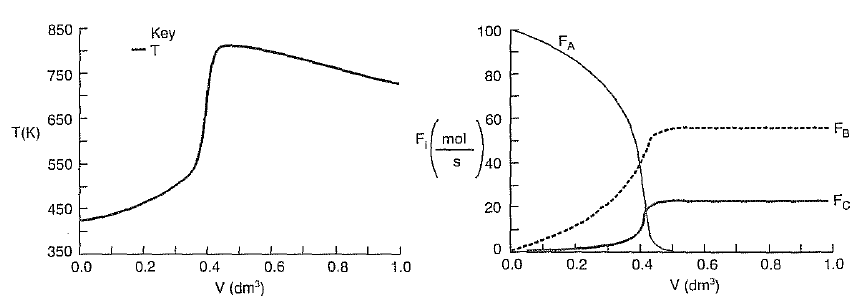

### Plot Temperature versus Volume

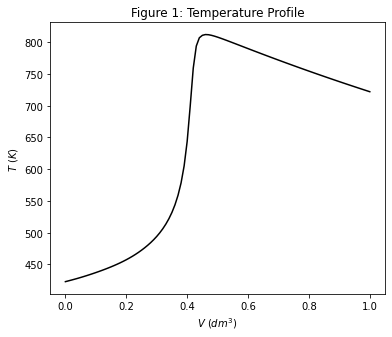

In [83]:
plt.figure(figsize=(6, 5))
plt.plot(V, T_soln,'k-')
plt.title('Figure 1: Temperature Profile')
plt.xlabel('$V\ (dm^3)$')
plt.ylabel('$T\ (K)$')
plt.show()

### Plot Molar Flow Rates versus Volume

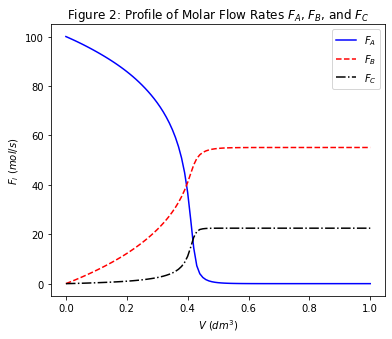

In [81]:
plt.figure(figsize=(6, 5))
line1, = plt.plot(V, F_A_soln,'b-')
line2, = plt.plot(V, F_B_soln, 'r--')
line3, = plt.plot(V, F_C_soln, 'k-.')
plt.title('Figure 2: Profile of Molar Flow Rates $F_{A}$, $F_{B}$, and $F_{C}$')
plt.legend((line1, line2, line3), ('$F_A$', '$F_B$', '$F_C$'))
plt.xlabel('$V\ (dm^3)$')
plt.ylabel('$F_{i} \ (mol/s)$')
plt.show()

## Reflection Questions
* Why are two plots helpful for displaying the results?
* Do the plots match the expected behavior of a PFR?
* Did you perform a dimensional analysis to ensure the given parameters' units and the solution's units match?
* Reduce the value of num in V_eval. Note that it must be an integer value. At approximately what value of num do the plots start to no longer look smooth (straight lines are drawn connecting adjacent evaluation points)?
* Explore changing line styles, colors. Are any of the options more visually appealing to you?